In [66]:
# Setup e Importazioni
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy

# Configurazione del seed per la riproducibilità
rnd = np.random
rnd.seed(0)

# Costo Massimo per gestire vincoli non rispettati (archi inesistenti)
MAX_COST = 9999999

In [67]:
# Definizione dei Dati del VRPTW (N=50)

n = 50    # Numero punti vendita
# Deposito: 's'=0 (partenza) e 't'=n+1 (arrivo)
xc = rnd.rand(n+1)*200     # Vettore di coordinate x dei vari nodi
xc = np.append(xc, xc[0])  # Coordinate x di 't' uguali a 's'
yc = rnd.rand(n+1)*100     # Vettore di coordinate y dei vari nodi
yc = np.append(yc, yc[0])  # Coordinate y di 't' uguali a 's'

P = [il for il in range(1,n+1)]        # Insieme P dei punti vendita (Clienti: 1 a 50)
N = [0] + P + [n+1]                    # Insieme N dei nodi ('s'=0, 't'=n+1)

# Insieme A degli archi
A = [(i,j) for i in N for j in N if i!=j and (i,j)!=(n+1,0) and (i,j)!=(0,n+1)]

# Costi associati a ogni arco
c = {(i,j): np.random.randint(2,15) for i,j in A}

# Tempo di percorrenza degli archi (posto come distanza euclidea)
t = {(i,j): int(np.hypot(xc[i]-xc[j], yc[i]-yc[j])) for i,j in A}

# Richiesta per ogni nodo
np.random.seed(0)
d = {i: np.random.randint(10,15) for i in P}
d[0] = 0        # Nodo deposito 's'
d[n+1] = 0      # Nodo deposito 't'

# Veicoli e Capacità
V = list(range(1, 11))
Q = {1:90, 2:90, 3:80, 4:80, 5:90, 6:90, 7:80, 8:80, 9:90, 10:100}

# Finestre di apertura dei punti di vendita
a = {}
b = {}
# Orari depositi
a[0], b[0] = 0, 1500
a[n+1], b[n+1] = 0, 1500
# Divisione in 3 fasce orarie: {[20,480], [50,900], [710, 1450]}
for i in P:
    r = i % 3
    if r == 1:
        a[i], b[i] = 20, 560
    elif r == 2:
        a[i], b[i] = 50, 1200
    else:
        a[i], b[i] = 710, 1450

# Tempo di servizio
s = {(i,k): np.random.randint(3,5) if i!=0 and i!=n+1 else 0 for i in N for k in V}

In [68]:
# Funzione di Vincolo: Capacità
def verifica_capacità (rotta, d, capacità):
    """Verifica che la domanda totale della rotta non superi la capacità del veicolo."""
    domanda_totale = sum(d[i] for i in rotta if i in d)
    return domanda_totale <= capacità

# Funzione di Vincolo: Finestra Temporale (VRPTW)
def verifica_finestra (rotta, t, s, a, b, veicolo_id):
    """Verifica che la rotta rispetti i tempi di arrivo (a, b) e i tempi di viaggio/servizio (t, s)."""
    n_plus_1 = len(P) + 1 # Indice del deposito di arrivo (t)

    tempo_corrente = 0
    nodo_precedente = 0  # Deposito di partenza (s)

    for i in rotta:
        # 1. Aggiornamento tempo di viaggio
        tempo_corrente += t.get((nodo_precedente, i), MAX_COST)
        if tempo_corrente >= MAX_COST: return False

        # 2. Tempo di attesa (se arrivo prima dell'apertura)
        if tempo_corrente < a[i]:
            tempo_corrente = a[i]

        # 3. Violazione della chiusura
        if tempo_corrente > b[i]:
            return False

        # 4. Aggiunta del tempo di servizio
        tempo_corrente += s.get((i, veicolo_id), 0)
        nodo_precedente = i

    # 5. Rientro al deposito (t)
    if (nodo_precedente, n_plus_1) in t:
        tempo_corrente += t.get((nodo_precedente, n_plus_1), MAX_COST)
        if tempo_corrente >= MAX_COST or tempo_corrente > b[n_plus_1]:
            return False

    return True

In [69]:
# Classe TabuSearch (con inizializzazione greedy e logica Tabu)

class TabuSearch:

    def __init__(self, P, c, t, d, a, b, V, Q, s, n_iters=1000, tabu_size=50):
        # Parametri del problema e Tabu Search
        self.P = P; self.c = c; self.t = t; self.d = d; self.a = a; self.b = b;
        self.V = V; self.Q = Q; self.s = s

        self.depot_s = 0
        self.depot_t = len(P) + 1 # Indice n+1 (deposito di arrivo)

        self.tabu_size = tabu_size
        self.n_iters = n_iters
        self.TABU = {}    # Lista Tabu (mossa -> tenure)

        # Stato della ricerca
        self.best_solution = None
        self.best_cost = MAX_COST
        self.current_solution = None
        self.current_cost = MAX_COST

    def _fitness(self, solution):
        """Calcola il costo totale di una soluzione (somma dei costi c degli archi)."""
        total_cost = 0
        for veiculo_id, route in solution.items():
            if route:
                # Costo Deposito (s) -> Primo Cliente
                total_cost += self.c.get((self.depot_s, route[0]), MAX_COST)

                # Costo tra i clienti
                for i in range(len(route) - 1):
                    total_cost += self.c.get((route[i], route[i+1]), MAX_COST)

                # Costo Ultimo Cliente -> Deposito (t)
                total_cost += self.c.get((route[-1], self.depot_t), MAX_COST)
        return total_cost

    def _is_feasible(self, solution):
        """Verifica i vincoli di capacità e finestra temporale per l'intera soluzione."""
        for veicolo_id, route in solution.items():
            if not verifica_capacità(route, self.d, self.Q[veicolo_id]):
                return False
            if not verifica_finestra(route, self.t, self.s, self.a, self.b, veicolo_id):
                return False
        return True

    def initialize_solution(self):
        """Genera una soluzione iniziale ammissibile (Strategia Greedy di Inserimento)."""
        remaining_clients = list(self.P)
        remaining_clients.sort(key=lambda c_id: self.b[c_id])
        initial_solution = {v: [] for v in self.V}

        max_attempts = len(self.P) * len(self.V) * 20
        attempt_count = 0

        while remaining_clients:
            client_to_assign = remaining_clients.pop(0)
            best_insertion = None
            min_route_cost = MAX_COST

            # Trova la migliore posizione di inserimento
            for veicolo_id in self.V:
                current_route = initial_solution[veicolo_id]
                for pos in range(len(current_route) + 1):
                    temp_route = current_route[:pos] + [client_to_assign] + current_route[pos:]

                    if self._is_feasible({veicolo_id: temp_route}):
                        # Valuta il costo della soluzione parziale (greedy)
                        temp_solution = deepcopy(initial_solution)
                        temp_solution[veicolo_id] = temp_route
                        new_cost = self._fitness(temp_solution)

                        if new_cost < min_route_cost:
                            min_route_cost = new_cost
                            best_insertion = (veicolo_id, temp_route)

            # Assegna o Riprova
            if best_insertion:
                veicolo_id, final_route = best_insertion
                initial_solution[veicolo_id] = final_route
            else:
                remaining_clients.append(client_to_assign)

            attempt_count += 1
            if attempt_count > max_attempts:
                raise Exception("Impossibile generare una soluzione iniziale ammissibile. Controlla i vincoli.")

        self.current_solution = initial_solution
        self.current_cost = self._fitness(initial_solution)
        self.best_solution = deepcopy(initial_solution)
        self.best_cost = self.current_cost

        return self.best_cost

    def find_neighborhood(self):
        """Genera vicini tramite mosse di SWAP (inter- e intra-rotta) ammissibili."""
        neighborhood = []
        moves = []
        current = self.current_solution
        vehicle_ids = list(current.keys())

        for v1_id in vehicle_ids:
            route1 = current[v1_id]
            for idx1 in range(len(route1)):
                node1 = route1[idx1]

                # 1. Swap Intra-Rotta
                for idx2 in range(idx1 + 1, len(route1)):
                    node2 = route1[idx2]
                    move = (node1, node2); inverse_move = (node2, node1)

                    if move not in self.TABU and inverse_move not in self.TABU:
                        new_solution = deepcopy(current)
                        new_route1 = new_solution[v1_id]
                        new_route1[idx1], new_route1[idx2] = new_route1[idx2], new_route1[idx1]

                        if self._is_feasible(new_solution):
                            neighborhood.append(new_solution)
                            moves.append(move)

                # 2. Swap Inter-Rotta
                for v2_id in vehicle_ids:
                    if v1_id != v2_id:
                        route2 = current[v2_id]
                        for idx2 in range(len(route2)):
                            node2 = route2[idx2]
                            move = (node1, node2); inverse_move = (node2, node1)

                            if move not in self.TABU and inverse_move not in self.TABU:

                                new_solution = deepcopy(current)
                                new_route1 = new_solution[v1_id]
                                new_route2 = new_solution[v2_id]

                                new_route1[idx1], new_route2[idx2] = new_route2[idx2], new_route1[idx1]

                                if self._is_feasible(new_solution):
                                    neighborhood.append(new_solution)
                                    moves.append(move)

        return neighborhood, moves

    def search(self):
        """Logica principale della Ricerca Tabu."""
        try:
            self.initialize_solution()
        except Exception as e:
            print(f"Errore: {e}")
            return None, None

        print(f"Inizio Ricerca Tabu. Costo iniziale: {self.best_cost:.2f}")

        for iter_count in range(self.n_iters):

            neighborhood, moves = self.find_neighborhood()

            if not neighborhood:
                print("Nessun vicino ammissibile trovato. Termine ricerca.")
                break

            best_candidate = None
            best_candidate_cost = MAX_COST
            best_move = None

            # Trova il miglior candidato e applica il Criterio di Aspirazione
            for nb, move in zip(neighborhood, moves):
                nb_cost = self._fitness(nb)
                is_tabu = move in self.TABU

                if not is_tabu or (is_tabu and nb_cost < self.best_cost):
                    if nb_cost < best_candidate_cost:
                        best_candidate_cost = nb_cost
                        best_candidate = nb
                        best_move = move

            # Aggiornamento dello Stato e Lista Tabu
            if best_candidate is not None:
                self.current_solution = best_candidate
                self.current_cost = best_candidate_cost

                if self.current_cost < self.best_cost:
                    self.best_cost = self.current_cost
                    self.best_solution = deepcopy(self.current_solution)

                if best_move is not None:
                    node1, node2 = best_move
                    inverse_move = (node2, node1)

                    self.TABU[best_move] = self.tabu_size
                    self.TABU[inverse_move] = self.tabu_size

            # Decremento del tenure
            moves_to_delete = []
            for move in list(self.TABU.keys()):
                self.TABU[move] -= 1
                if self.TABU[move] <= 0:
                    moves_to_delete.append(move)

            for move in moves_to_delete:
                del self.TABU[move]

            if (iter_count + 1) % 100 == 0:
                print(f"Iterazione {iter_count+1}/{self.n_iters} - Costo corrente: {self.current_cost:.2f} | Costo migliore: {self.best_cost:.2f}")

        print(f"\nRicerca Tabu completata. Costo Finale: {self.best_cost:.2f}")
        return self.best_solution, self.best_cost

In [70]:
# Esecuzione dell'algoritmo
ts = TabuSearch(P=P, c=c, t=t, d=d, a=a, b=b, V=V, Q=Q, s=s, n_iters=1000, tabu_size=50)
final_solution, final_cost = ts.search()

# Stampa Risultati
print("\n--- Risultati Finali ---")
if final_solution is not None and final_cost is not None:
    print(f"Costo Totale Finale: {final_cost:.2f}")
    print("Soluzione (Rotta per Veicolo, solo Nodi Cliente):")
    for veicolo, rotta in final_solution.items():
        if rotta:
            print(f"Veicolo {veicolo} (Cap. {Q[veicolo]}): Rotta di {len(rotta)} clienti: {rotta}")
else:
    print("Nessuna soluzione ammissibile trovata dopo la fase di inizializzazione.")

Inizio Ricerca Tabu. Costo iniziale: 276.00
Iterazione 100/1000 - Costo corrente: 179.00 | Costo migliore: 174.00
Iterazione 200/1000 - Costo corrente: 188.00 | Costo migliore: 170.00
Iterazione 300/1000 - Costo corrente: 191.00 | Costo migliore: 170.00
Iterazione 400/1000 - Costo corrente: 198.00 | Costo migliore: 170.00
Iterazione 500/1000 - Costo corrente: 204.00 | Costo migliore: 170.00
Iterazione 600/1000 - Costo corrente: 194.00 | Costo migliore: 170.00
Iterazione 700/1000 - Costo corrente: 190.00 | Costo migliore: 170.00
Iterazione 800/1000 - Costo corrente: 194.00 | Costo migliore: 170.00
Iterazione 900/1000 - Costo corrente: 183.00 | Costo migliore: 170.00
Iterazione 1000/1000 - Costo corrente: 184.00 | Costo migliore: 170.00

Ricerca Tabu completata. Costo Finale: 170.00

--- Risultati Finali ---
Costo Totale Finale: 170.00
Soluzione (Rotta per Veicolo, solo Nodi Cliente):
Veicolo 1 (Cap. 90): Rotta di 7 clienti: [46, 40, 22, 4, 49, 43, 16]
Veicolo 2 (Cap. 90): Rotta di 7 cli

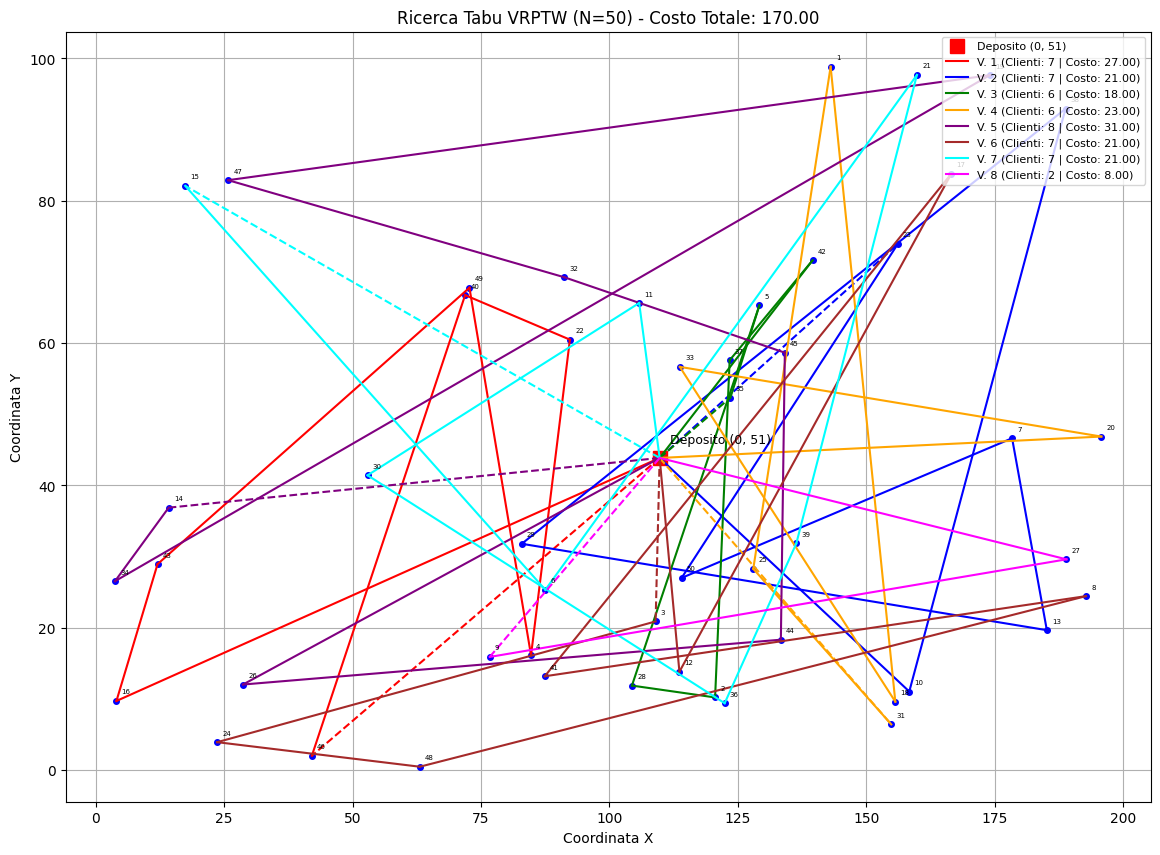

In [71]:
# Visualizzazione della Soluzione Ottima

# Colori per i 10 veicoli
colori = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta', 'lime', 'gold']

plt.figure(figsize=(14, 10))

# Disegna i nodi e il deposito
plt.plot(xc[0], yc[0], 'rs', markersize=10, label=f'Deposito (0, {n+1})')
plt.text(xc[0]+2, yc[0]+2, f'Deposito (0, {n+1})', fontsize=9)

for i in P:
    plt.plot(xc[i], yc[i], 'bo', markersize=4)
    plt.annotate(f"{i}", (xc[i]+1, yc[i]+1), fontsize=5)

# Disegna le rotte
if final_solution is not None:
    for k, rotta in final_solution.items():
        col = colori[(k-1) % len(colori)]

        if rotta:
            # Calcolo del costo della rotta (per la legenda)
            rotta_costo = ts._fitness({k:rotta})

            # 1. Deposito (0) -> Primo cliente
            plt.plot([xc[0], xc[rotta[0]]], [yc[0], yc[rotta[0]]], color=col, linewidth=1.5, linestyle='--')

            # 2. Percorso tra i clienti
            for i in range(len(rotta) - 1):
                n1, n2 = rotta[i], rotta[i+1]
                plt.plot([xc[n1], xc[n2]], [yc[n1], yc[n2]], color=col, linewidth=1.5)

            # 3. Ultimo cliente -> Deposito (n+1)
            plt.plot([xc[rotta[-1]], xc[n+1]], [yc[rotta[-1]], yc[n+1]],
                     color=col, linewidth=1.5,
                     label=f'V. {k} (Clienti: {len(rotta)} | Costo: {rotta_costo:.2f})',
                     linestyle='-')

# Legenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=8)

plt.title(f"Ricerca Tabu VRPTW (N={n}) - Costo Totale: {final_cost:.2f}")
plt.xlabel("Coordinata X")
plt.ylabel("Coordinata Y")
plt.grid(True)
plt.show()